In [1]:
%load_ext autoreload
%autoreload 2

from tfga import GeometricAlgebra
import tensorflow as tf
import tensorflow_probability as tfp

# Quantum Electrodynamics with Geometric Algebra

## Theory overview
Quantum Electrodynamics (QED) describes electrons, positrons (anti-electrons) and photons in a 4-dimensional spacetime with fields defined for all spacetime positions $X$. The 4-dimensional spacetime can be described by the [Spacetime Algebra (STA)](https://en.wikipedia.org/wiki/Spacetime_algebra) with basis vectors $\gamma_0, \gamma_1, \gamma_2, \gamma_3$ and corresponding metric $[1, -1, -1, -1]$. It contains two fields. The electron-positron field is a bispinor-field $\psi(X)$ which in the context of Geometric Algebra (GA) is described by even-grade multivectors of the STA. The photon field $A(X)$ is a vector-field (ie. multivectors of degree 1, one basis for each dimension).

A field configuration, also known as a path, $P(X)$ contains values for the two fields at every spacetime position. Our goal is to calculate the QED action using GA which allows us to use algorithms that solve for field configurations . The action is the negative log-likelihood (NLL) of the field configuration, meaning it is a number which tells how likely a given field configuration is. It is not a probability as it is unnormalized. However even with only the NLL we can use sampling algorithms (eg. [Markov-Chain Monte-Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo), [Variational Inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods)) to sample field configurations so that the sampled distribution matches the normalized distribution.

The Lagrangian is given in Hestenes' article [Real Dirac Theory](https://www.researchgate.net/publication/266578033_REAL_DIRAC_THEORY) in equation (B.6) as

$\mathcal{L} = \langle \hbar (\nabla \psi(X)) i \gamma_3 \widetilde{\psi}(X) - e A(X) \psi(X) \gamma_0 \widetilde{\psi}(X) - m \psi(X) \widetilde{\psi}(X) \rangle$

where $\langle ... \rangle$ denotes getting the scalar part, $i = \gamma_2 \gamma_1$, $\nabla = \sum_{i=0}^{3} \gamma_i \delta^i$ and $\widetilde{\psi}(X)$ is the grade-reversal of $\psi$.

The action $S(P)$ for a field-configuration $P=(\psi, A)$ is calculated by integrating the Lagrangian $\mathcal{L}(P, X)$ over all space-time positions $X$.

$S(\psi, A) = \int_{X \in \mathcal{X}} \mathcal{L}(\psi, A, X) dx$

Finally as we are doing this numerically we need to discretize spacetime into a 4-dimensional grid. Integrals over spacetime then become sums over the grid. Derivatives become finite-differences or more complicated operations to avoid the [aliasing](https://arxiv.org/abs/hep-lat/0207008) which results in the [fermion doubling](https://en.wikipedia.org/wiki/Fermion_doubling) problem.

## Getting started
Let's start by defining the spacetime algebra as a geometric algebra in 1 time and 3 space dimensions with metric $[1, -1, -1, -1]$.

In [2]:
sta = GeometricAlgebra([1, -1, -1, -1])
for basis in sta.basis_mvs:
    sta.print(basis)

MultiVector[1.00*e_0]
MultiVector[1.00*e_1]
MultiVector[1.00*e_2]
MultiVector[1.00*e_3]


We can see our four basis vectors displayed here each with a different ... basis. Let's try squaring them.

In [3]:
sta.print("e_0^2:", sta.geom_prod(sta.basis_mvs[0], sta.basis_mvs[0]))
sta.print("e_1^2:", sta.geom_prod(sta.basis_mvs[1], sta.basis_mvs[1]))
sta.print("e_2^2:", sta.geom_prod(sta.basis_mvs[2], sta.basis_mvs[2]))
sta.print("e_3^2:", sta.geom_prod(sta.basis_mvs[3], sta.basis_mvs[3]))

e_0^2: MultiVector[1.00*1]
e_1^2: MultiVector[-1.00*1]
e_2^2: MultiVector[-1.00*1]
e_3^2: MultiVector[-1.00*1]


Squaring the basis vectors gave us back another purely scalar multivector. The squared bases indeed return the correct metric.

We can create new multivectors of different kinds using the geometric algebra `sta_ga` object. Let's create some vectors such as the elements of the photon field and perform some operations to get a feel for them. We can use the methods on `sta_ga`, most of which take a `batch_shape` that says how many elements you want (`[]` meaning just a single one) and a `kind` that describes which elements it will set (eg. `"even"`, `"mv"` (meaning all), `"vector"`, `"scalar"`, ...). Alternatively we can just build everything out of the basis vectors ourselves by adding and multiplying them.

In [5]:
v1 = sta.from_tensor_with_kind(tf.ones(4), kind="vector")
sta.print("v1:", v1)

v2 = sta.basis_mvs[0] + sta.basis_mvs[1]
sta.print("v2:", v2)

sta.print("v1 * v2 (Geometric product):", sta.geom_prod(v1, v2))
sta.print("v1 | v2 (Inner product):", sta.inner_prod(v1, v2))
sta.print("v1 ^ v2 (Exterior product):", sta.ext_prod(v1, v2))

v3 = v1 + v2
sta.print("v3 = v1 + v2:", v3)
sta.print("v1 | v3:", sta.inner_prod(v1, v3))
sta.print("v1 ^ v3:", sta.ext_prod(v1, v3))

v4 = sta.geom_prod(v1, v2)
sta.print("v4 = v1 * v2:", v3)
sta.print("v1^-1 * v4:", sta.geom_prod(sta.inverse(v1), v4), "should be", v2)

v1: MultiVector[1.00*e_0 + 1.00*e_1 + 1.00*e_2 + 1.00*e_3]
v2: MultiVector[1.00*e_0 + 1.00*e_1]
v1 * v2 (Geometric product): MultiVector[-1.00*e_02 + -1.00*e_03 + -1.00*e_12 + -1.00*e_13]
v1 | v2 (Inner product): MultiVector[]
v1 ^ v2 (Exterior product): MultiVector[-1.00*e_02 + -1.00*e_03 + -1.00*e_12 + -1.00*e_13]
v3 = v1 + v2: MultiVector[2.00*e_0 + 2.00*e_1 + 1.00*e_2 + 1.00*e_3]
v1 | v3: MultiVector[-2.00*1]
v1 ^ v3: MultiVector[-1.00*e_02 + -1.00*e_03 + -1.00*e_12 + -1.00*e_13]
v4 = v1 * v2: MultiVector[2.00*e_0 + 2.00*e_1 + 1.00*e_2 + 1.00*e_3]
v1^-1 * v4: MultiVector[1.00*e_0 + 1.00*e_1] should be MultiVector[1.00*e_0 + 1.00*e_1]


Now let's do the same for the bispinors (elements of even degree).

In [6]:
b1 = sta.from_tensor_with_kind(tf.ones(8), kind="even")
sta.print("b1:", b1)

b2 = sta.from_scalar(4.0) + sta.geom_prod(sta.basis_mvs[0], sta.basis_mvs[1]) + sta.geom_prod(sta.basis_mvs[0], sta.basis_mvs[1])
sta.print("b2:", b2)

sta.print("b1 | b2:", sta.inner_prod(b1, b2))
sta.print("b1 ^ b2:", sta.ext_prod(b1, b2))

b3 = sta.geom_prod(b1, b2)
sta.print("b3 = b1 * b2:", b3)
sta.print("b3 * b2^-1:", sta.geom_prod(b3, sta.inverse(b2)), "should be", b1)

sta.print("~b2 (Grade reversal):", sta.reversion(b2))
sta.print("Scalar part of b2:", sta.keep_blades(b2, ""))
sta.print("e_01 part of b2:", sta.keep_blades(b2, "01"))

b1: MultiVector[1.00*1 + 1.00*e_01 + 1.00*e_02 + 1.00*e_03 + 1.00*e_12 + 1.00*e_13 + 1.00*e_23 + 1.00*e_0123]
b2: MultiVector[4.00*1 + 2.00*e_01]
b1 | b2: MultiVector[6.00*1 + 6.00*e_01 + 4.00*e_02 + 4.00*e_03 + 4.00*e_12 + 4.00*e_13 + 6.00*e_23 + 4.00*e_0123]
b1 ^ b2: MultiVector[4.00*1 + 6.00*e_01 + 4.00*e_02 + 4.00*e_03 + 4.00*e_12 + 4.00*e_13 + 4.00*e_23 + 6.00*e_0123]
b3 = b1 * b2: MultiVector[6.00*1 + 6.00*e_01 + 6.00*e_02 + 6.00*e_03 + 6.00*e_12 + 6.00*e_13 + 6.00*e_23 + 6.00*e_0123]
b3 * b2^-1: MultiVector[1.00*1 + 1.00*e_01 + 1.00*e_02 + 1.00*e_03 + 1.00*e_12 + 1.00*e_13 + 1.00*e_23 + 1.00*e_0123] should be MultiVector[1.00*1 + 1.00*e_01 + 1.00*e_02 + 1.00*e_03 + 1.00*e_12 + 1.00*e_13 + 1.00*e_23 + 1.00*e_0123]
~b2 (Grade reversal): MultiVector[4.00*1 + -2.00*e_01]
Scalar part of b2: MultiVector[batch_shape=(1, 1)]
e_01 part of b2: MultiVector[batch_shape=(1, 1)]


Now we hopefully have some feel for how to operate with the geometric algebra numbers. So far we only worked with single numbers, but we can define a field (ie. a number for every grid point) by passing in a `batch_shape` that is the size of our grid. When printing the fields we won't see the actual numbers anymore, we will only see which blades are non-zero and the batch shape. However we can still access all of the numbers with the usual indexing rules.

In [8]:
a = sta.from_tensor_with_kind(tf.ones((10, 10, 10, 10, 4)), kind="vector")
sta.print("A(X):", a)

sta.print("A(t=0, x=5, y=3, z=9):", a[0, 5, 3, 9])
sta.print("A(t=0, z=[3,4,5]):", a[0, :, :, 3:6])
sta.print("e_0 part of A(X):", sta.select_blades(a, "0").shape)

sta.print("A(0, 0, 0, 0) * ~A(0, 0, 0, 0):", sta.geom_prod(a, sta.reversion(a))[0, 0, 0, 0])

A(X): MultiVector[batch_shape=(10, 10, 10, 10)]
A(t=0, x=5, y=3, z=9): MultiVector[1.00*e_0 + 1.00*e_1 + 1.00*e_2 + 1.00*e_3]
A(t=0, z=[3,4,5]): MultiVector[batch_shape=(10, 10, 3)]
e_0 part of A(X): (10, 10, 10, 10, 1)
A(0, 0, 0, 0) * ~A(0, 0, 0, 0): MultiVector[-2.00*1]


By now you will probably believe me that we can do the same to create a bispinor field, so instead let's see how we can calculate derivatives.

As mentioned in the beginning, derivatives become finite differences. To calculate finite differences we can take a copy of the field, shift it back by one in a dimension and subtract it. For instance of we were to calculate the derivative
in the time direction we would shift the entire field by -1 along the time axis to get `A(X + TimeDirection * GridSpacing)` and subtract the actual field from this shifted field. All that is left then is to divide by the grid spacing.

`d/dt A(X) = (A(X + TimeDirection * GridSpacing) - A(X)) / GridSpacing`

To actually do the shifting we will use the `with_changes` method which allows copying of the multivector and overriding of its blade values so we will just shift the blade values themselves using [tf.roll](https://www.tensorflow.org/api_docs/python/tf/roll). A better abstraction that doesn't require using the internal blade values might be added later.

In [3]:
def finite_differences(field, axis, spacing):
    shifted_field = tf.roll(field, shift=-1, axis=axis)
    return (shifted_field - field) / spacing

In [ ]:
deriv_t_a = finite_differences(a, axis=0, spacing=0.1)
sta.print("d/dt A(X) = (A(X + TimeDirection * GridSpacing) - A(X)) / GridSpacing:", deriv_t_a)
sta.print("d/dt A(0, 0, 0, 0):", deriv_t_a[0, 0, 0, 0])

Maybe expectedly, as our field is just a constant value everywhere, we are left with a field that is zero everywhere. Now we have a finite differences operation that will work on fields of any kind.

Now we have all the tools we need to actually calculate the QED action given a field configuration. As a reminder, the QED Lagrangian is given by

$\mathcal{L} = \langle \hbar (\nabla \psi(X)) i \gamma_3 \widetilde{\psi}(X) - e A(X) \psi(X) \gamma_0 \widetilde{\psi}(X) - m \psi(X) \widetilde{\psi}(X) \rangle$

and the action $S(\psi, A)$ is the spacetime integral (now sum) over it.

Let's start with the mass term on the right $m \psi(X) \widetilde{\psi}(X)$.

In [4]:
def get_mass_term(psi, electron_mass):
    return electron_mass * sta.geom_prod(psi, sta.reversion(psi))

In [ ]:
# Define psi as some arbitrary even-graded field for now
psi = sta.from_tensor_with_kind(tf.ones([10, 10, 10, 10, 8]), kind="even") + sta.from_tensor_with_kind(tf.ones([10, 10, 10, 10, 1]), kind="scalar")
sta.print("Psi:", psi)
sta.print("Psi at (0, 0, 0, 0):", psi[0, 0, 0, 0])

# The electron mass in planck units (hbar=1, c=1) is actually not 1 but something tiny.
# However we won't bother with it for now.
mass_term = get_mass_term(psi=psi, electron_mass=1.0)
sta.print("Mass term:", mass_term)
sta.print("Mass term at (0, 0, 0, 0):", mass_term[0, 0, 0, 0])

Next the interaction term in the center that describes the scattering between the electron-positron field and the photon field $e A(X) \psi(X) \gamma_0 \widetilde{\psi}(X)$.

In [5]:
def get_interaction_term(psi, a, electron_charge):
    return sta.geom_prod(electron_charge * a, sta.geom_prod(psi, sta.geom_prod(sta.e("0"), sta.reversion(psi))))

In [ ]:
interaction_term = get_interaction_term(psi=psi, a=a, electron_charge=1.0)
sta.print("Interaction term:", interaction_term)
sta.print("Interaction term at (0, 0, 0, 0):", interaction_term[0, 0, 0, 0])

And finally the momentum term for which we needed the finite differences $\hbar (\nabla \psi(X)) i \gamma_3 \widetilde{\psi}(X)$.

In [6]:
def get_momentum_term(psi, spacing, hbar):
    # Nabla Psi
    dt_psi = finite_differences(psi, axis=0, spacing=spacing)
    dx_psi = finite_differences(psi, axis=1, spacing=spacing)
    dy_psi = finite_differences(psi, axis=2, spacing=spacing)
    dz_psi = finite_differences(psi, axis=3, spacing=spacing)
    d_psi = dt_psi + dx_psi + dy_psi + dz_psi

    return sta.geom_prod(hbar * d_psi, sta.geom_prod(sta.e("213"), sta.reversion(psi)))

In [ ]:
momentum_term = get_momentum_term(psi=psi, spacing=0.1, hbar=1.0)

sta.print("Momentum term:", momentum_term)
sta.print("Momentum term at (0, 0, 0, 0):", momentum_term[0, 0, 0, 0]) # Still zero ;(

Now that we have all the terms, we can add them up, sum over all grid points and take the scalar part to get the action.

In [7]:
def get_action(psi, a, spacing, electron_mass, electron_charge, hbar):
    mass_term = get_mass_term(psi=psi, electron_mass=electron_mass)
    interaction_term = get_interaction_term(psi=psi, a=a, electron_charge=electron_charge)
    momentum_term = get_momentum_term(psi=psi, spacing=spacing, hbar=hbar)

    # Sum terms and get scalar part
    lagrangians = (momentum_term - mass_term - interaction_term)[..., 0]

    # Sum lagrangians (one lagrangian for each spacetime point) over spacetime
    # to get a single value, the action.
    return tf.reduce_sum(lagrangians)

In [ ]:
action = get_action(psi=psi, a=a, spacing=0.1, electron_mass=1.0, electron_charge=1.0, hbar=1.0)
print("Action:", action)

Now that we can calculate the action for a given field configuration (ie. values for `psi` and `a` at every grid point) we could use a sampling algorithm
to sample fields and calculate quantities of interest such as the correlation function, vacuum energy and more.

In [82]:
def joint_log_prob(psi_config, a_config):
    mv_psi_config = sta.from_tensor_with_kind(psi_config, "even")
    mv_a_config = sta.from_tensor_with_kind(a_config, "vector")

    action = get_action(mv_psi_config, mv_a_config, spacing=0.1, electron_mass=1e-8,
                        electron_charge=0.0, hbar=1.0) # 0.0854245

    # Action is the negative log likelihood of the fields, and since
    # the sampling function expects a (positive) log likelihood,
    # we return the negation.
    return -action

num_chains = 1

@tf.function(experimental_compile=False)
def sample(initial_state, step_size):
    return tfp.mcmc.sample_chain(
        num_results=100,
        num_burnin_steps=5000,
        current_state=initial_state,
        kernel=tfp.mcmc.NoUTurnSampler(
            target_log_prob_fn=joint_log_prob,
            step_size=step_size
        ),
        trace_fn=None
    )

gs = 3 # grid size
initial_state = [
    # Psi (bispinor field, 8 components)
    # A (vector field, 4 components)
    tf.zeros((num_chains, gs, gs, gs, gs, 8), dtype=tf.float32),
    tf.zeros((num_chains, gs, gs, gs, gs, 4), dtype=tf.float32)
]

variable_step_size = [0.05, 0.05]

chain_samples = sample(initial_state, variable_step_size)

In [83]:
print(chain_samples[0].shape)
print(chain_samples[1].shape)
print(tf.reduce_sum(tf.abs(chain_samples[0][0, 0] - chain_samples[0][1, 0])))

(100, 1, 3, 3, 3, 3, 8)
(100, 1, 3, 3, 3, 3, 4)
tf.Tensor(0.0, shape=(), dtype=float32)


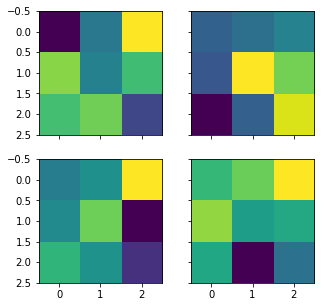

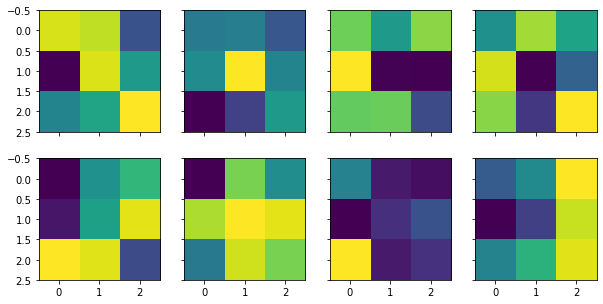

In [84]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(5, 5))
for i in range(4):
    ax = axes[i % 2][i // 2]
    im = ax.imshow(chain_samples[1][0, 0, 0, 0, :, :, i])
fig.show()

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 5))
for i in range(8):
    ax = axes[i % 2][i // 2]
    ax.imshow(chain_samples[0][0, 0, 0, 0, :, :, i])
fig.show()

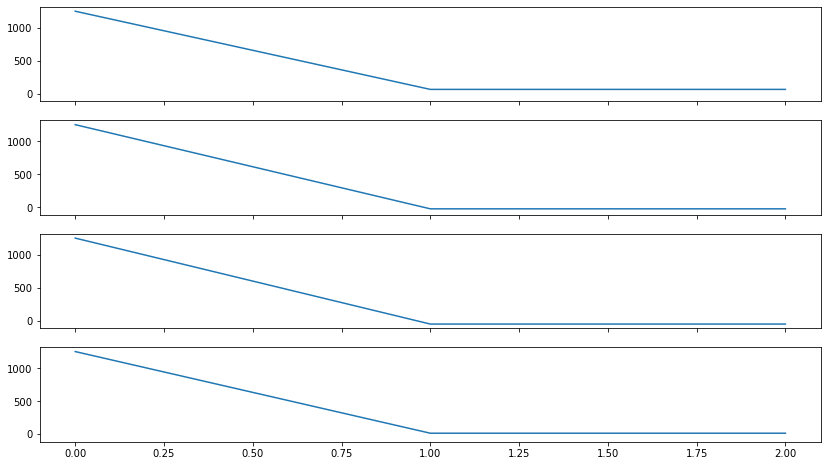

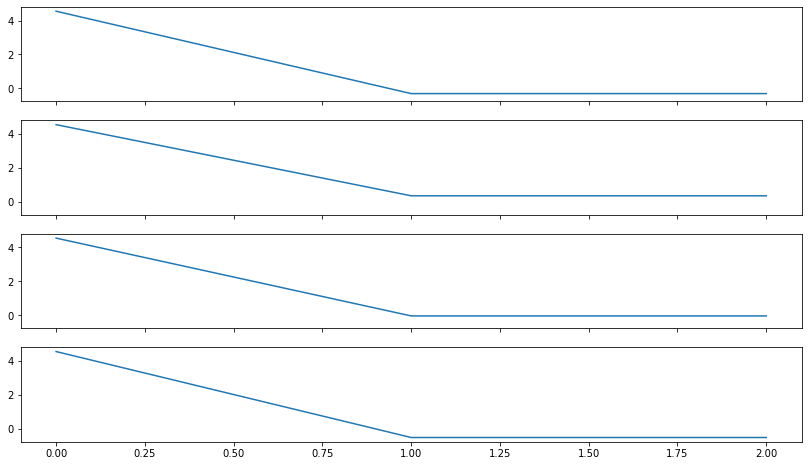

In [85]:
def plot_correlations(ax, samples, axis):
    correlation_by_shift = []
    for i in range(samples.shape[axis]):
        shifted = tf.roll(samples, shift=-i, axis=axis)
        correlation_by_shift.append(tf.reduce_mean(shifted * samples))
    ax.plot(correlation_by_shift)

fig, axes = plt.subplots(4, sharex=True, sharey=True, figsize=(14, 8))
plot_correlations(axes[0], chain_samples[0], axis=-2)
plot_correlations(axes[1], chain_samples[0], axis=-3)
plot_correlations(axes[2], chain_samples[0], axis=-4)
plot_correlations(axes[3], chain_samples[0], axis=-5)

fig, axes = plt.subplots(4, sharex=True, sharey=True, figsize=(14, 8))
plot_correlations(axes[0], chain_samples[1], axis=-2)
plot_correlations(axes[1], chain_samples[1], axis=-3)
plot_correlations(axes[2], chain_samples[1], axis=-4)
plot_correlations(axes[3], chain_samples[1], axis=-5)